# Volume 3: Kalman Filter
    <Name>
    <Class>
    <Date>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

## Problem 1

Begin implementing a KalmanFilter class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

## Problem 3

Add a method evolve() to your KalmanFilter class to generate a state and observation sequence by evolving the system from a given initial state.


## Problem 4
Add code to your KalmanFilter class to estimate a state sequence corresponding to a given observation sequence and initial state estimate by implementing the estimate() method.

## Problem 6

Add a function predict() to your class that predicts the next $k$ states given a current state estimate but in the absence of observations.

## Problem 8
Add a function rewind() to your class that rewinds the system from a given state estimate, returning predictions for the previous states. 

In [13]:

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # initialize
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        self.n = F.shape[0]
        self.m = H.shape[0]
        self.G = np.eye(self.n)
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        # set up
        states = np.empty((self.n, N))
        obs = np.empty((self.m, N))
        states[:, 0] = x0
        obs[:, 0] = self.H @ x0 + np.random.multivariate_normal(np.zeros(self.m), self.R)

        # iterate through the other states & observations
        for i in range(1, N):
            states[:, i] = self.F @ states[:, i - 1] + self.G @ self.u + np.random.multivariate_normal(np.zeros(self.n), self.Q)
            obs[:, i] = self.H @ states[:, i] + np.random.multivariate_normal(np.zeros(self.m), self.R)
        
        return states, obs      

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # set up estimates
        estimates = np.zeros((self.n, z.shape[1]))
        estimates[:, 0] = x0

        # iterate through the other state estimates
        for i in range(1, z.shape[1]):
            P_k = self.F @ P0 @ self.F.T + self.Q
            x_k_1 = self.F@estimates[:, i-1] + self.u

            # compute kalman gain
            K = P_k @ self.H.T @ inv(self.H @ P_k @ self.H.T + self.R)

            # update state estimate
            estimates[:, i] = x_k_1 + K @ (z[:, i - 1] - self.H @ x_k_1)

            # update error covariance matrix
            P0 = (np.eye(self.n) - K @ self.H) @ P_k

        return estimates
            
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        # set up
        predicted = np.zeros((self.n, k))
        predicted[:, 0] = self.F @ x + self.G @ self.u

        # iterate through the other predicted states
        for i in range(1, k):
            # update
            predicted[:, i] = self.F @ predicted[:, i - 1] + self.G @ self.u

        return predicted   
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        # set up
        out = np.empty((self.n, k))
        
        # iterate
        for i in list(range(k-1, -1, -1)):
            out_i = np.linalg.inv(self.F) @ (x - self.u)
            out[:,i] = out_i
            x = out_i
        
        return out


## Problem 2 

Work out the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to the projectile. 
Assume that the noise covariances are given by 

$\begin{align*}
    Q &= 0.1 \cdot I_4 \\
    R &= 5000 \cdot I_2.
\end{align*}$

Instantiate a KalmanFilter object with these values.

In [14]:
# initialize
F = np.array([[1, 0, 0.1, 0],[0, 1, 0, 0.1], [0, 0, 1, 0],[0, 0, 0, 1]])
Q = 0.1*np.eye(4)
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = 5000*np.eye(2)
u = np.array([0, 0, 0, -0.98])
# instantiate kalman filter
kf = KalmanFilter(F,Q,H,R,u)

## Problem 3

Simulate the true and observed trajectory of a projectile with initial state

$\begin{equation*}
    x_0 = \left( \begin{array}{c} 0 \\ 0 \\ 300 \\ 600 \end{array} \right).
\end{equation*}$

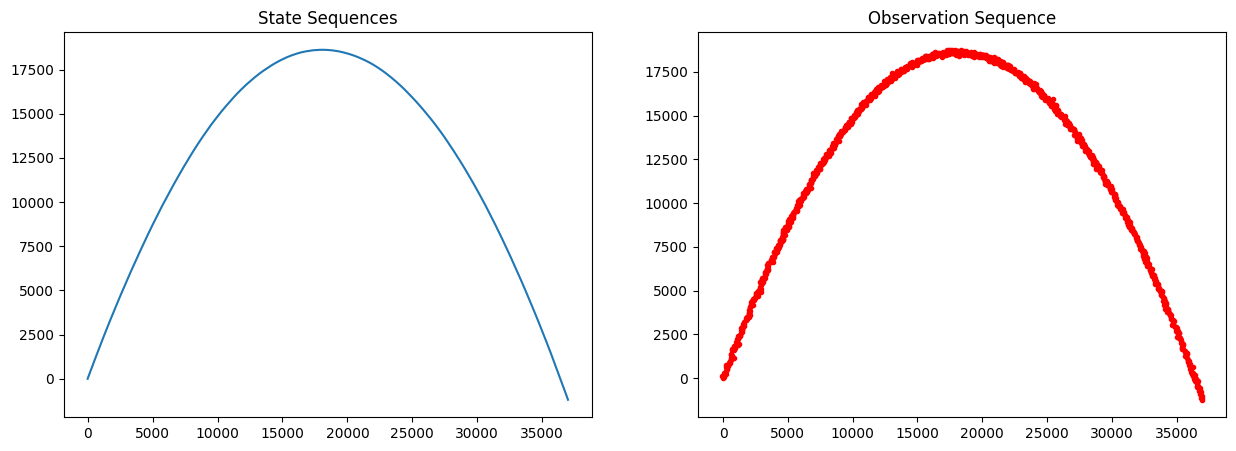

In [15]:
# set up
x_0 = np.array([0,0,300,600])
N = 1250
states, obs = kf.evolve(x_0,N)

# plot
plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(states[0,:],states[1,:])
plt.title("State Sequences")

plt.subplot(1, 2, 2)
plt.plot(obs[0,:],obs[1,:],'r.')
plt.title("Observation Sequence")

plt.show()


## Problem 5

Calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.
Using the initial state estimate, $P_{200} = 10^6\cdot Q$, and your Kalman Filter, compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
Zoom in to see how well it follows the true path. 

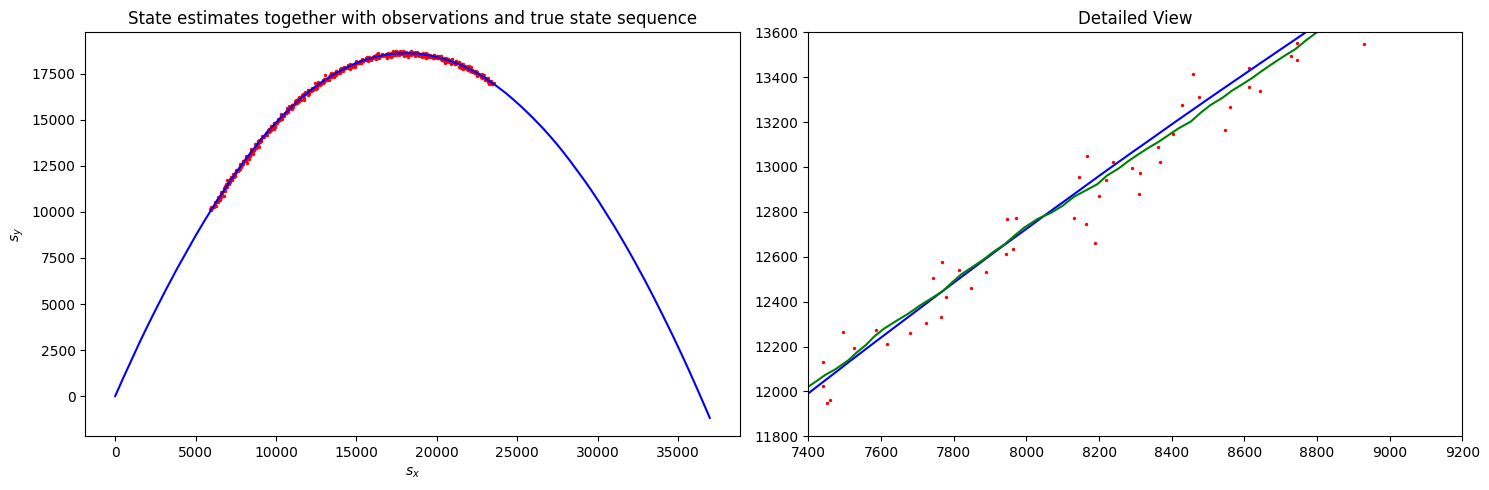

In [16]:
# Use the initial state estimate P_200 = 10^6*Q
P_200 = 1000000 * Q
horiz = states[0, 200]
vert = states[1, 200]
vel_horiz = np.mean(np.diff(states[2, 200:210]))
vel_vert = np.mean(np.diff(states[3, 200:210]))
x_200 = np.array([horiz, vert, vel_horiz, vel_vert])

# get next 600 state estimates
estimates = kf.estimate(x_200, P_200, obs[:, 201:801])

trunc_states = states[:, 201:801]
z = obs[:, 201:801]

# plot!
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(z[0], z[1], color="red", s=2)
plt.plot(states[0, :], states[1, :], color="blue")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.title('State estimates together with observations and true state sequence')

plt.subplot(1, 2, 2)
plt.plot(trunc_states[0], trunc_states[1], color="blue")
plt.plot(estimates[0], estimates[1], color="green")
plt.scatter(z[0], z[1], color="red", s=2)
plt.xlim([7400, 9200])
plt.ylim([11800, 13600])
plt.title('Detailed View')

plt.tight_layout()
plt.show()

## Problem 7

Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 5, predict the future states of the projectile until it hits the ground. 
Predicting approximately the next 450 states should be sufficient.
Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

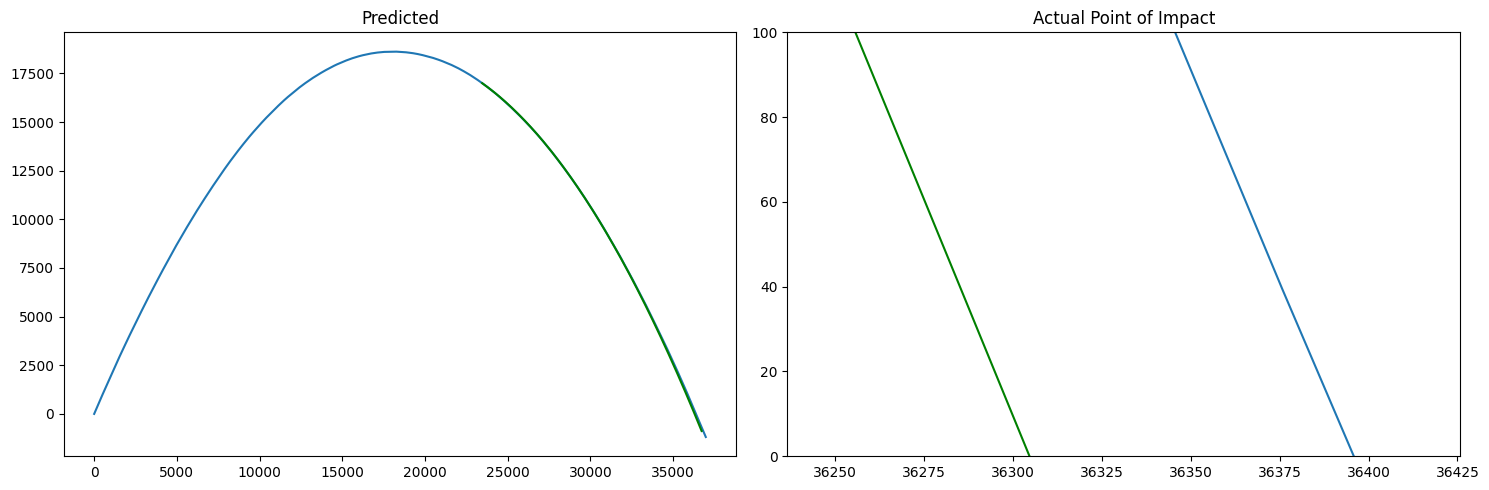

In [17]:
# predict
predicted = kf.predict(estimates[:, -1], 450)

plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(states[0, :], states[1,: ])
plt.plot(predicted[0, :], predicted[1, :], 'g')
plt.title('Predicted')

plt.subplot(1, 2, 2)
plt.plot(states[0,:],states[1,:])
plt.plot(predicted[0, :], predicted[1, :], 'g')
x1 = states[0,:][np.where(states[1,:]>=0)][-1]
x2 = predicted[0,:][np.where(predicted[1,:]>=0)][-1]
plt.xlim(min(x1,x2)-50, max(x1,x2)+50)
plt.ylim(0, 100)
plt.title('Actual Point of Impact')

plt.tight_layout()
plt.show()

## Problem 9

Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250. 
Note that you may have to take a few extra time steps to predict the point of origin. 
Plot these predicted states (in green) together with the original state sequence. 
Zoom in to see how accurate your prediction is. 
Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$. 
Compare to the previous results. 
Which is better? 
Why?

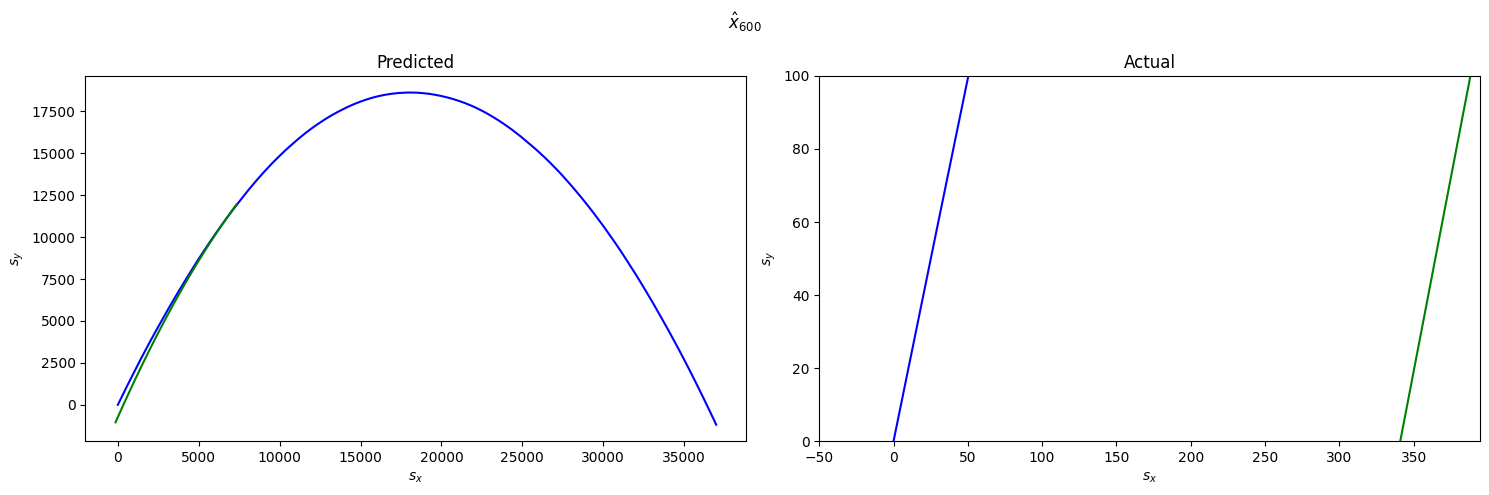

In [22]:
# set up
x = estimates[:,49]
k = 260
preds = kf.rewind(x,k)

x1 = states[0,:][np.where(states[1,:]>=0)][0]
x2 = preds[0,:][np.where(preds[1,:]>=0)][0]
xlb, xub = min(x1,x2)-50, max(x1,x2)+50

# plot
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(states[0], states[1], color="b")
plt.plot(preds[0], preds[1], color="g")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.title('Predicted')

plt.subplot(1,2,2)
plt.plot(states[0],states[1],color="b")
plt.plot(preds[0],preds[1],color="g")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.xlim([xlb,xub])
plt.ylim([0,100])
plt.title('Actual')

plt.suptitle('$\hat{x}_{600}$')
plt.tight_layout()
plt.show()

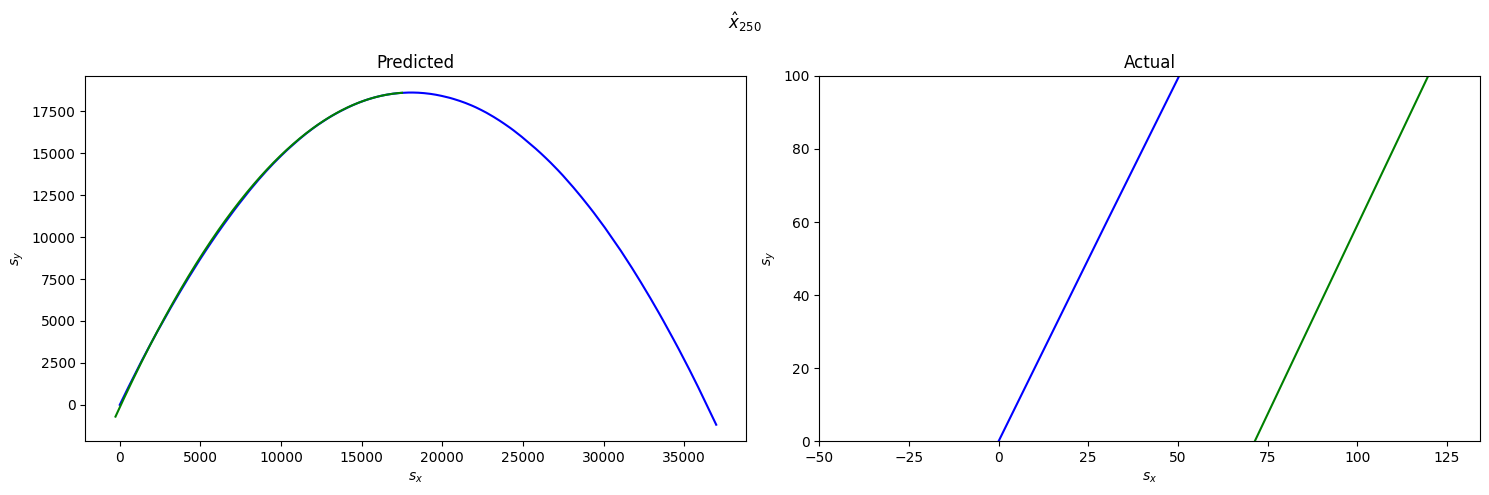

In [23]:
# set up
x = estimates[:, 399]
k = 610
preds = kf.rewind(x, k)

x1 = states[0,:][np.where(states[1,:]>=0)][0]
x2 = preds[0,:][np.where(preds[1,:]>=0)][0]
xlb, xub = min(x1,x2)-50, max(x1,x2)+50

# plot
plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(states[0], states[1], color="b")
plt.plot(preds[0], preds[1], color="g")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.title('Predicted')

plt.subplot(1,2,2)
plt.plot(states[0],states[1],color="b")
plt.plot(preds[0],preds[1],color="g")
plt.xlabel("$s_{x}$")
plt.ylabel("$s_{y}$")
plt.xlim([xlb,xub])
plt.ylim([0,100])
plt.title('Actual')

plt.suptitle('$\hat{x}_{250}$')
plt.tight_layout()
plt.show()

The prediction starting from $\hat{\mathbf{x}}_{250}$ is better because it is closer to the actual trajectory, indicating a more accurate estimate of the projectile's origin. This higher accuracy is likely due to the reduced accumulation of error when predicting from an earlier state.